In [1]:
import random, glob, os
from termcolor import colored
import math
from datetime import datetime
import h5py                         # pip install h5py
import pywt                         # pip install PyWavelets
from tqdm import tqdm               # pip install tqdm
import matplotlib.pyplot as plt     # pip install matplotlib
import cv2                          # pip install opencv-python
import numpy as np                  # pip install numpy
from prettytable import PrettyTable # pip install prettytable

# for torch installation, follow https://pytorch.org/get-started/locally/ or https://pytorch.org/get-started/previous-versions/
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from utils.common import get_save_path, get_load_path, normalize_dataset
from utils.save_load_model import save_model, load_model
from utils.metrics import get_CM, get_AUROC, get_IoU, compute_metrics, nice_print, compute_avg_metrics, compute_best_classifier
from utils.matlab_imresize import imresize
from utils.model import Model, create_model
from utils.classifier import train_classifier, test_classifier
from utils.log_funcs import *

2025-02-27 11:32:09.897184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740652329.956513  285388 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740652329.978861  285388 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

####### PARAMETERS #######
debug_mode = True

wavelet_type = "DWT" # "DWT" or "CWT"

dataset = "BBB" # "ACPdata" or "BBB"

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_path = f"model_checkpoints_{dataset}_{wavelet_type}_{timestamp}"

siz = 224  # size of the image (siz x siz x 3) to feed to resnet model

classifiers_num = 1

max_epochs = 2

train_batch_size = 32

initial_learning_rate = 1e-4
scheduler_rate = 0.8
lr_last_fc_weight = 20

# The following wavelets are also available: 'dmey', 'fk4', 'beyl', 'vaid'
# Consult the PyWavelets documentation for a complete list of available wavelets
if wavelet_type=="DWT":
    wavelets = np.array(['haar', 'db6', 'sym6', 'coif2', 'bior2.2', 'rbio2.2'])
elif wavelet_type=="CWT":
    wavelets = np.array(['cgau6', 'cmor', 'fbsp', 'gaus6', 'mexh', 'morl', 'shan'])
else:
    quit("Invalid wavelet type")

## Loading Features data

Here are the data vectors that are going to be transformed into 3-channel matrices.

Then, a model must learn how to classify each vector

In [4]:
# Opens an HDF5 file and retrieves its items.
# variables (ItemsView): The items in the HDF5 file.
if dataset=="BBB":
    fBBB = h5py.File('datasets/BBBfold.mat','r')
elif dataset=="ACPdata":
    fBBB = h5py.File('datasets/ACPdata.mat','r')
else:
    quit("Invalid dataset")
variables = fBBB.items()

### Notes for the BBB dataset
data size is: C x N = 1119 x 7162 (where C is the number of channels and N is the number of data samples) <br>
we have N=7162 samples, each has C=1119 features. <br>
This dataset is divided 10 folds, each using 6446 samples for train and 716 for validation
 - 6446 + 716 = 7162 (~90% for train and ~10% for valid)<br>

The test set (referred to as dataIND and labels labelIND)  has size 1119x74, that is 74 samples.<br>

The next cell prints all the variables in the dataset

In [5]:
max_s = max([len(var[0]) for var in variables])
for var in variables:
    name = var[0]
    data = np.array(fBBB.get(name))
    print(f"{name} {' '*(max_s-len(name))} {data.shape}")

#refs#            (51,)
I                 (43, 1)
Perf              (2, 10)
a                 (74, 1)
ans               (1, 1)
b                 (74, 1)
data              (1119, 7162)
dataIND           (1119, 74)
fid               (1, 1)
fold              (1, 1)
idTE              (10, 1)
idTR              (10, 1)
indices           (1, 7162)
label             (7162, 1)
labelDATA         (7162, 1)
labelIND          (74, 1)
labelTE           (10, 1)
labelTR           (10, 1)
pattern           (1, 1)
scoreLibIND       (2, 74)
scoreLibSVMnoRed  (10, 1)
test              (1, 716)
train             (1, 6446)


In [6]:
data     = np.array(fBBB.get("data")).T ## e.g. for BBB: shape: (1119, 7162) to (7162, 1119) with transposition
numFolds = np.array(fBBB.get("idTR")).shape[0]
print("numFolds", numFolds)

numFolds 10


In [7]:
# Shuffle features for each channel (3 in total)
NumberOfFeatures = data.shape[1]
print("NumberOfFeatures", NumberOfFeatures)
np.random.seed(1337)
# ord = {canale: np.random.permutation(NumberOfFeatures) for canale in range(3)}
ord = {canale: np.argsort(np.random.random(NumberOfFeatures)) for canale in range(3)}
print(f"ord is a dict with {len(ord.items())} items, each has len {ord[0].shape[0]}")

NumberOfFeatures 1119
ord is a dict with 3 items, each has len 1119


In [8]:
# Randomly select mother wavelets for each band (3 bands in total)
np.random.seed(1337)
SelectedWave = {}
for band in range(3):
    Selected = []
    for choose in range(len(wavelets)):
        # Randomly shuffle wavelets and store the indices
        SW = np.argsort(np.random.random(len(wavelets)))
        Selected.append(SW)
    SelectedWave[band] = np.array(Selected).reshape(-1)
print("SelectedWave:", type(SelectedWave), "len:", len(SelectedWave), "each band has shape", SelectedWave[0].shape)

SelectedWave: <class 'dict'> len: 3 each band has shape (36,)


# vector2image function
HERE is where you have to modify the code. Choose btw vector2image_DWT and vector2image_CWT.
 > Just one is sufficient

You already find the baseline version of the functions.
 > Play with them to gain confidence with the task

In [9]:
def vector2image_DWT(network_features, L=2):

    long = network_features.shape[0]>500

    IM = []
    for band in range(3):
        ordband = ord[band]
        
        # Reorder data sample (aka network_features) using the shuffling indexes ordband
        vector = network_features[ordband]

        # Initialize the matrix with zeros
        N = int(np.ceil(vector.shape[0]/(2*L)))
        N_safe = N + 200
        
        matrix = np.zeros((N_safe, N_safe)); ## to account for the long vectors ca/cd ("avoid lossy")
        
        num_levels = int(np.log2(len(vector)))

        # wavelet sets extraction
        row = 0
        OrigVector = vector.copy()
        esco = False
        NumWave = len(SelectedWave[band])
        diffWavelet = 1

        max_ca = -1
        
        while True:
            vector=OrigVector.copy()
    
            # Fill the matrix with the wavelet coefficients
            for i in range(num_levels-4):
                wavelet_index = SelectedWave[band][diffWavelet % NumWave]
                wavelet_type = wavelets[wavelet_index]
                
                ca, cd = pywt.dwt(vector, wavelet_type, mode="symmetric")
                
                if long and i==0:
                    ca = imresize(ca[None].T, output_shape=(np.ceil(ca.shape[0]/2), 1))[:, 0]
                    cd = imresize(cd[None].T, output_shape=(np.ceil(cd.shape[0]/2), 1))[:, 0]
                    
                vector = ca

                if len(ca)>max_ca:
                    max_ca = len(ca)

                matrix[row,   :ca.shape[0]] = ca
                matrix[row+1, :cd.shape[0]] = cd
                row += 2
                
                if row>max_ca:
                    esco=True
                    break
            
            if esco:
                break
            diffWavelet += 1

        matrix = matrix[:row, :max_ca]
        IM.append(matrix)
    
    IMA = [imresize(IM[i], output_shape=(224, 224)) for i in range(len(IM))]
    IM = np.array(IMA)
    return IM

In [10]:
def vector2image_CWT(network_features, L=2):
    New_IM = []

    for band in range(3):
        ordband = ord[band]
        
        # Sample vector of length 'n'
        ## OR: reorder data sample (aka network_features) using the shuffling indexes ordband
        vector = network_features[ordband]
        sizeFeat = vector.shape[0]
        
        # we divide the feature vector in sub-windows of size 1% of the total length
        BL = np.ceil(sizeFeat/100)
        IM = []
        for sottoM in range(0, sizeFeat, int(BL)):
            net_feat = network_features[sottoM:min(sottoM + int(BL), sizeFeat)]  # sub-window

            IM.append(pywt.cwt(net_feat, np.arange(1, len(net_feat)+1), wavelets[SelectedWave[band][0]])[0])  # Continuous wavelet transform

        # it stores the matrix obtained concatenating the 100 outputs of the above CWT
        IMM = []
        step_idx = 0
        for row in range(10):
            IMMcl=[]
            for col in range(10):
                try:
                    Blocco = IM[step_idx]
                except IndexError:
                    Blocco = np.zeros((IM[0].shape[0], IM[0].shape[1]))
                if Blocco.shape[0] < IM[0].shape[0] or Blocco.shape[1] < IM[0].shape[1]:  # padding for the right size
                    padded_Blocco = np.zeros((IM[0].shape[0], IM[0].shape[1]))
                    padded_Blocco[:Blocco.shape[0], :Blocco.shape[1]] = Blocco
                    Blocco = padded_Blocco
                IMMcl.append(Blocco)
                step_idx += 1
            
            IMMcl = np.concatenate(IMMcl, axis=1)

            IMM.append(IMMcl)
        
        IMM = np.concatenate(IMM, axis=0)
    
        New_IM.append(IMM)

    # Resize the image to 224x224
    IMA = [imresize(New_IM[i], output_shape=(224, 224)) for i in range(len(New_IM))]
    IM = np.array(IMA)
    return IM

In [11]:
if wavelet_type=="CWT":
    vector2image = vector2image_CWT
elif wavelet_type=="DWT":
    vector2image = vector2image_DWT
else:
    quit("Invalid wavelet type")

## Visualize an example

normalizing dataset with shape (100, 1119)


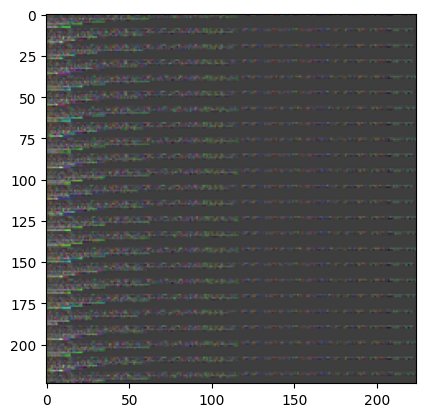

In [12]:
subset_data = data[:100, :]

# 1. normalize data
norm_data, _, _ = normalize_dataset(subset_data)

# 2. pick a vector at random and convert it to an image
idx = np.random.randint(0, norm_data.shape[0])
IM = vector2image(norm_data[idx])

# # 3. imshow wants the channel dimension to be the last one
IM = np.transpose(IM, (1, 2, 0))

# # 4. normalize the image to [0, 1] range for visualization
IMA = ((IM - IM.min()) / (IM.max() - IM.min()))

plt.imshow(IMA)

## Model

### GenerativeDataset

In [13]:
class GenerativeDataset(Dataset):
    def __init__(self, fBBB, fold, mode="TR", siz=224, normalization=None, downsize=False):
       
        self.siz = siz

        if dataset == "BBB":
            keys = {"train": ["data", "label"], "test": ["dataIND", "labelIND"], "valid": ["data", "label"]}
        elif dataset=="ACPdata":
            keys = {"train": ["FeatureTR", "labelTR"], "test": ["FeatureTE", "labelTE"], "valid": ["FeatureTE", "labelTE"]}
        
        if fold is not None:
            data = np.array(fBBB.get("data")).T

            self.idxs = np.array(fBBB.get(fBBB.get(f"id{mode}")[fold, 0]))[0].astype(int) -1

            print("creating dataset with mode", mode, "fold", fold)

            ## reduce the dataset sample in favor of speed
            ## set this option in prototyping phase, convergence should happen
            if downsize:
                self.idxs_t = [self.idxs[idx] for idx in range(len(self.idxs)) if idx%10==0]
                print("downsizing from", len(self.idxs), "to", len(self.idxs_t))
                self.idxs = np.array(self.idxs_t)
            
            self.vectors = data[self.idxs, :]
            if dataset=="BBB":
                self.labels = np.array(fBBB.get("label"))[:, 0][self.idxs].astype(int) -1
            else:
                self.labels = np.array(fBBB.get(np.array(fBBB.get(keys[mode][1])[0])[0]))[0].astype(int) - 1
        else:
            
            self.vectors = np.array(fBBB.get(keys[mode][0])).T
            
            if dataset=="BBB":
                self.labels = np.array(fBBB.get(keys[mode][1]))[:, 0].astype(int) -1
            else:
                self.labels = np.array(fBBB.get(np.array(fBBB.get(keys[mode][1])[0])[0]))[0].astype(int) - 1

            if downsize:
                self.idxs = np.arange(0, self.vectors.shape[0])
                np.random.seed(1337); np.random.shuffle(self.idxs)
                self.idxs_t = [self.idxs[idx] for idx in range(len(self.idxs)) if idx%10==0]
                print("downsizing from", len(self.idxs), "to", len(self.idxs_t))
                self.idxs = np.array(self.idxs_t)
                self.vectors = self.vectors[self.idxs, :]
                self.labels = self.labels[self.idxs].astype(int)

            if mode=="valid":
                self.idxs = np.arange(0, self.vectors.shape[0])
                np.random.seed(1337)
                np.random.shuffle(self.idxs)
                self.idxs = self.idxs[:int(0.2 * len(self.idxs))]
                self.vectors = self.vectors[self.idxs, :]
                self.labels = self.labels[self.idxs].astype(int)

        assert self.vectors.shape[0] == self.labels.shape[0], str(self.vectors.shape[0]) + " and " + str(self.labels.shape[0]) + " don't match!"

        if normalization is None:
            self.vectors, min_, max_ = normalize_dataset(self.vectors)
            self.min_ = min_
            self.max_ = max_
        else:
            self.vectors, _, _ = normalize_dataset(self.vectors, min_along_cols=normalization[0], max_along_cols=normalization[1])

        ## compute class weights to help the Loss function to stabilize
        ## since the dataset is heavily unbalanced
        self.w_0 = self.labels.shape[0] / (2 * (self.labels==0).sum())
        self.w_1 = self.labels.shape[0] / (2 * (self.labels==1).sum())
        
        print("negatives:", (self.labels==0).sum(), "/", self.labels.shape[0], "w_0", self.w_0)
        print("positives:", (self.labels==1).sum(), "/", self.labels.shape[0], "w_1", self.w_1)
        
    def __len__(self):
        return len(self.vectors)
        
    def __getitem__(self, idx):
        network_features=self.vectors[idx, :]
        IM = vector2image(network_features)
        IM = np.transpose(IM, (1, 2, 0))
        lab = self.labels[idx]
        return IM, lab

## Normalize the "images" to mean 0 and variance 1
As you studied in the course, this helps the network to learn and speeds up convergence.

In [14]:
def calculate_mean_std(loader):
    mean = std = total_images = 0
    
    for images, _ in tqdm(loader):
        # Permute images to [N, 3, 224, 224] and reshape to [N, 3, -1] for easier mean/std calculation
        images = images.permute(0, 3, 1, 2)
        images = images.view(images.size(0), images.size(1), -1)
        mean  += images.mean(2).sum(0)
        std   += images.std(2).sum(0)
        total_images += images.size(0)

    mean /= total_images
    std /= total_images
    return mean, std

## Train

## (only for BBB) Cross-Validation Training on all the folds

In [ ]:
if dataset == "ACPdata":
    print("do not train with cross validation on ACPdata")
    print("you're only given a single fold")
else:
    classifier_idx = 0  ## modify this to save different classifiers test results

    results = []
    # numFolds = 2
    for fold_idx in range(numFolds):
        print(colored(f"starting fold {fold_idx} / {numFolds}", "yellow"))
        trainset = GenerativeDataset(fBBB, fold=fold_idx, mode="TR", normalization=None, downsize=False)
        validset = GenerativeDataset(fBBB, fold=fold_idx, mode="TE", normalization=(trainset.min_, trainset.max_), downsize=False)

        trainloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
        validloader = DataLoader(validset, batch_size=1,  shuffle=False)

        LOG_loss_weights((trainset.labels==0).sum(), (trainset.labels==1).sum(), trainset.w_0, trainset.w_1, classifier_idx, fold_idx, path=out_path)
        
        # the dataset is unbalanced -> use weighted loss
        loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([trainset.w_0, trainset.w_1]).to(device))

        print(f"Computing fold {fold_idx:2d} mean and std...")
        if debug_mode:
            mean, std = torch.Tensor([12.8338, 12.8575, 12.7818]), torch.Tensor([29.4589, 30.2996, 29.5237])
            print(f"skipping mean and std computation to speed up (DEBUG MODE ON). using mean: {mean}, std: {std}")
        else:
            mean, std = calculate_mean_std(trainloader)
            print(f"Calculated mean: {mean}, std: {std}")

        LOG_norm(mean, std, classifier_idx, fold_idx, path=out_path)

        normalize_transform = torchvision.transforms.Normalize(mean=mean, std=std)
        
        model, optimizer, scheduler = create_model(
                                            ilr = initial_learning_rate,
                                            scheduler_rate = scheduler_rate,
                                            lr_last_fc_weight = lr_last_fc_weight
                                        )
        
        LOG_training_hyperparams(initial_learning_rate, scheduler_rate, lr_last_fc_weight, train_batch_size, classifier_idx, fold_idx, path=out_path)

        res = train_classifier(model, optimizer, scheduler, loss_function, normalize_transform, trainloader, validloader, max_epochs, classifier_idx, fold_idx, out_path, debug=debug_mode)
        results.append(res)

    avg_metrics = compute_avg_metrics(results)
    print("Results for classifier", classifier_idx); nice_print(avg_metrics)

    LOG_metrics(avg_metrics, msg=f"Results for classifier {classifier_idx}", classifier_idx=classifier_idx, fold_idx=-1, path=out_path)


## Train a single classifier on the full dataset

In [17]:
avg_results = []

trainset = GenerativeDataset(fBBB, fold=None, mode="train", normalization=None, downsize=False)
validset = GenerativeDataset(fBBB, fold=None, mode="valid", normalization=(trainset.min_, trainset.max_), downsize=False)

trainloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=1,  shuffle=False)

# the dataset is unbalanced -> use weighted loss
loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([trainset.w_0, trainset.w_1]).to(device))

print(f"Computing fold {fold_idx:2d} mean and std...")
if debug_mode:
    mean, std = torch.Tensor([12.8338, 12.8575, 12.7818]), torch.Tensor([29.4589, 30.2996, 29.5237])
    print(f"skipping mean and std computation to speed up (DEBUG MODE ON). using mean: {mean}, std: {std}")
else:
    mean, std = calculate_mean_std(trainloader)
    print(f"Calculated mean: {mean}, std: {std}")
normalize_transform = torchvision.transforms.Normalize(mean=mean, std=std)

for classifier_idx in range(classifiers_num):
    print(colored(f"Training classifier {classifier_idx+1}/{classifiers_num}", "yellow"))
    LOG_loss_weights((trainset.labels==0).sum(), (trainset.labels==1).sum(), trainset.w_0, trainset.w_1, classifier_idx, fold_idx=None, path=out_path)
    LOG_norm(mean, std, classifier_idx, fold_idx=None, path=out_path)
    
    model, optimizer, scheduler = create_model(
                                        ilr = initial_learning_rate,
                                        scheduler_rate = scheduler_rate,
                                        lr_last_fc_weight = lr_last_fc_weight
                                    )
    
    LOG_training_hyperparams(initial_learning_rate, scheduler_rate, lr_last_fc_weight, train_batch_size, classifier_idx, fold_idx=None, path=out_path)

    res = train_classifier(model, optimizer, scheduler, loss_function, normalize_transform, trainloader, validloader, max_epochs, classifier_idx, fold_idx=None, path=out_path, debug=debug_mode)
    avg_results.append(res)
    
    
avg_metrics = compute_avg_metrics(avg_results)
print(colored(f"Results for classifier {classifier_idx}", "yellow")); nice_print(avg_metrics)

avg_results_valid = [c_res["best_metrics_valid"] for c_res in avg_results]

print(colored("Best results among classifiers", "yellow"))

best_classifiers, best_values = compute_best_classifier(avg_results_valid)

for key, classifier_idx in best_classifiers.items():
    if key == "loss":
        print(f"Best classifier for {key} is classifier {classifier_idx} with value {best_values[key]:.4f}")
    else:
        print(f"Best classifier for {key} is classifier {classifier_idx} with value {best_values[key]*100:.2f}%")


normalizing dataset with shape (7162, 1119)
negatives: 5453 / 7162 w_0 0.6567027324408582
positives: 1709 / 7162 w_1 2.095377413692218
normalizing dataset with shape (1432, 1119)
negatives: 1096 / 1432 w_0 0.6532846715328468
positives: 336 / 1432 w_1 2.130952380952381
Computing fold  2 mean and std...
skipping mean and std computation to speed up (DEBUG MODE ON). using mean: tensor([12.8338, 12.8575, 12.7818]), std: tensor([29.4589, 30.2996, 29.5237])
Training classifier 1/1
Training classifier 0 on the whole dataset


  0%|          | 0/224 [00:01<?, ?it/s, avg_train_loss=0.7199]


epoch [0  ] - train
+--------+--------+--------+--------+----------+--------+----------+
| Metric |  IoU+  |  IoU-  | IoUavg | Accuracy |  AUC   | Avg Loss |
+--------+--------+--------+--------+----------+--------+----------+
| Value  | 29.63% | 20.83% | 25.23% |  40.62%  | 55.31% |  0.7199  |
+--------+--------+--------+--------+----------+--------+----------+
+-------------------+--------------------+--------------------+
| Confusion Matrix: | Predicted Negative | Predicted Positive |
+-------------------+--------------------+--------------------+
|  Actual Negative  |        5.0         |        18.0        |
|  Actual Positive  |        1.0         |        8.0         |
+-------------------+--------------------+--------------------+


  0%|          | 0/1432 [00:00<?, ?it/s, avg_valid_loss=0.5866]


epoch [0  ] -  valid
+--------+-------+---------+--------+----------+--------+----------+
| Metric |  IoU+ |   IoU-  | IoUavg | Accuracy |  AUC   | Avg Loss |
+--------+-------+---------+--------+----------+--------+----------+
| Value  | 0.00% | 100.00% | 50.00% | 100.00%  | 50.00% |  0.5866  |
+--------+-------+---------+--------+----------+--------+----------+
+-------------------+--------------------+--------------------+
| Confusion Matrix: | Predicted Negative | Predicted Positive |
+-------------------+--------------------+--------------------+
|  Actual Negative  |        1.0         |        0.0         |
|  Actual Positive  |        0.0         |        0.0         |
+-------------------+--------------------+--------------------+


  0%|          | 0/224 [00:01<?, ?it/s, avg_train_loss=0.7409]


epoch [1  ] - train
+--------+--------+--------+--------+----------+--------+----------+
| Metric |  IoU+  |  IoU-  | IoUavg | Accuracy |  AUC   | Avg Loss |
+--------+--------+--------+--------+----------+--------+----------+
| Value  | 20.00% | 25.93% | 22.96% |  37.50%  | 55.13% |  0.7409  |
+--------+--------+--------+--------+----------+--------+----------+
+-------------------+--------------------+--------------------+
| Confusion Matrix: | Predicted Negative | Predicted Positive |
+-------------------+--------------------+--------------------+
|  Actual Negative  |        7.0         |        19.0        |
|  Actual Positive  |        1.0         |        5.0         |
+-------------------+--------------------+--------------------+


  0%|          | 0/1432 [00:00<?, ?it/s, avg_valid_loss=0.5889]


epoch [1  ] -  valid
+--------+-------+---------+--------+----------+--------+----------+
| Metric |  IoU+ |   IoU-  | IoUavg | Accuracy |  AUC   | Avg Loss |
+--------+-------+---------+--------+----------+--------+----------+
| Value  | 0.00% | 100.00% | 50.00% | 100.00%  | 50.00% |  0.5889  |
+--------+-------+---------+--------+----------+--------+----------+
+-------------------+--------------------+--------------------+
| Confusion Matrix: | Predicted Negative | Predicted Positive |
+-------------------+--------------------+--------------------+
|  Actual Negative  |        1.0         |        0.0         |
|  Actual Positive  |        0.0         |        0.0         |
+-------------------+--------------------+--------------------+
Results for classifier 0
+--------+-------+---------+--------+----------+--------+----------+
| Metric |  IoU+ |   IoU-  | IoUavg | Accuracy |  AUC   | Avg Loss |
+--------+-------+---------+--------+----------+--------+----------+
| Value  | 0.00% |

## Evaluate the ensemble on the test set

In [18]:
avg_results = []
all_logits = []
trainset = GenerativeDataset(fBBB, fold=None, mode="train", normalization=None, downsize=False)
trainloader = DataLoader(trainset, batch_size=train_batch_size,  shuffle=True)

print(f"Computing fold {fold_idx:2d} mean and std...")
if debug_mode:
    mean, std = torch.Tensor([12.8338, 12.8575, 12.7818]), torch.Tensor([29.4589, 30.2996, 29.5237])
    print(f"skipping mean and std computation to speed up (DEBUG MODE ON). using mean: {mean}, std: {std}")
else:
    mean, std = calculate_mean_std(trainloader)
    print(f"Calculated mean: {mean}, std: {std}")

testset    = GenerativeDataset(fBBB, fold=None, mode="test", normalization=(trainset.min_, trainset.max_), downsize=False)
testloader = DataLoader(testset, batch_size=1,  shuffle=False)

loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([trainset.w_0, trainset.w_1]).to(device))

for classifier_idx in range(classifiers_num):
    model, optimizer, _ = create_model(
                                ilr = initial_learning_rate,
                                scheduler_rate = scheduler_rate,
                                lr_last_fc_weight = lr_last_fc_weight
                            )
    model, _, _, _ = load_model(model, optimizer, classifier_idx, fold_idx=None, path=out_path)
    res, logits = test_classifier(model, loss_function, testloader, normalize_transform)
    
    print(colored(f"Results for classifier {classifier_idx}", "yellow")); nice_print(res)

    avg_results.append(res)
    all_logits.append(logits)
  
avg_metrics = compute_avg_metrics(avg_results)

print(colored(f"average test results", "yellow")); nice_print(avg_metrics)

best_classifiers, best_values = compute_best_classifier(avg_results)

for key, classifier_idx in best_classifiers.items():
    if key == "loss":
        print(f"Best classifier for {key} is classifier {classifier_idx} with value {best_values[key]:.4f}")
    else:
        print(f"Best classifier for {key} is classifier {classifier_idx} with value {best_values[key]*100:.2f}%")



## EVALUATE ENSEMBLE MODEL
all_logits = np.array(all_logits)

# Combine logits using the sum rule
ensemble_logits = torch.Tensor(np.sum(all_logits, axis=0))
ensemble_pred = (torch.nn.functional.softmax(ensemble_logits, dim=1).argmax(dim=1).int().numpy()).tolist()
ensemble_gt = testset.labels

# Compute metrics for the ensemble model
ensemble_metrics = compute_metrics(ensemble_pred, ensemble_gt)
print(colored("Ensemble model results", "yellow"))
nice_print(ensemble_metrics)

normalizing dataset with shape (7162, 1119)
negatives: 5453 / 7162 w_0 0.6567027324408582
positives: 1709 / 7162 w_1 2.095377413692218
Computing fold  2 mean and std...
skipping mean and std computation to speed up (DEBUG MODE ON). using mean: tensor([12.8338, 12.8575, 12.7818]), std: tensor([29.4589, 30.2996, 29.5237])
normalizing dataset with shape (74, 1119)
negatives: 39 / 74 w_0 0.9487179487179487
positives: 35 / 74 w_1 1.0571428571428572


100%|██████████| 74/74 [00:04<00:00, 17.21it/s, avg_test_loss=12.8104]

Results for classifier 0
+--------+-------+--------+--------+----------+--------+----------+
| Metric |  IoU+ |  IoU-  | IoUavg | Accuracy |  AUC   | Avg Loss |
+--------+-------+--------+--------+----------+--------+----------+
| Value  | 9.30% | 44.29% | 26.79% |  47.30%  | 45.46% | 12.8104  |
+--------+-------+--------+--------+----------+--------+----------+
+-------------------+--------------------+--------------------+
| Confusion Matrix: | Predicted Negative | Predicted Positive |
+-------------------+--------------------+--------------------+
|  Actual Negative  |        31.0        |        8.0         |
|  Actual Positive  |        31.0        |        4.0         |
+-------------------+--------------------+--------------------+
average test results
+--------+-------+--------+--------+----------+--------+----------+
| Metric |  IoU+ |  IoU-  | IoUavg | Accuracy |  AUC   | Avg Loss |
+--------+-------+--------+--------+----------+--------+----------+
| Value  | 9.30% | 44.29% 